In [107]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
from PhysicsDatasets import SHODatasetXV, DampedSHODatasetXV, DampedSHODatasetV2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import json
from matplotlib.colors import LogNorm
from utils import load_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
dset = DampedSHODatasetV2(seq_len=5,min_seq_length=1,vary_length=True)
loader = torch.utils.data.DataLoader(dset,batch_size=4)

In [119]:
np.round(4/3)

1.0

In [122]:
a = [1,2,3,4,5]
a[-4:]

[2, 3, 4, 5]

# time series for a range of masses

In [23]:
model_name = "random_DampedSHO_xvInput_noContext"
#date = "17Dec24_1621"
date = "06Jan25_1255"
model, kwargs = load_model(model_name,date)

Using RoPE
number of parameters: 0.20M


In [24]:
masses = torch.arange(1,11.1,0.1)
max_seq_length = 65
n_seq = 20
val_data = DampedSHODatasetXV(masses=masses,seq_len=max_seq_length,dt=kwargs['dt'])

x = val_data.xv
ctx = val_data.context

tstart = 20
nstep = max_seq_length - tstart
xcurr = x[:,:tstart,:]
with torch.no_grad():
    for i in range(nstep):
        x_next = model(xcurr)
        xcurr = torch.cat([xcurr,x_next[:,-1:,:]],dim=1)

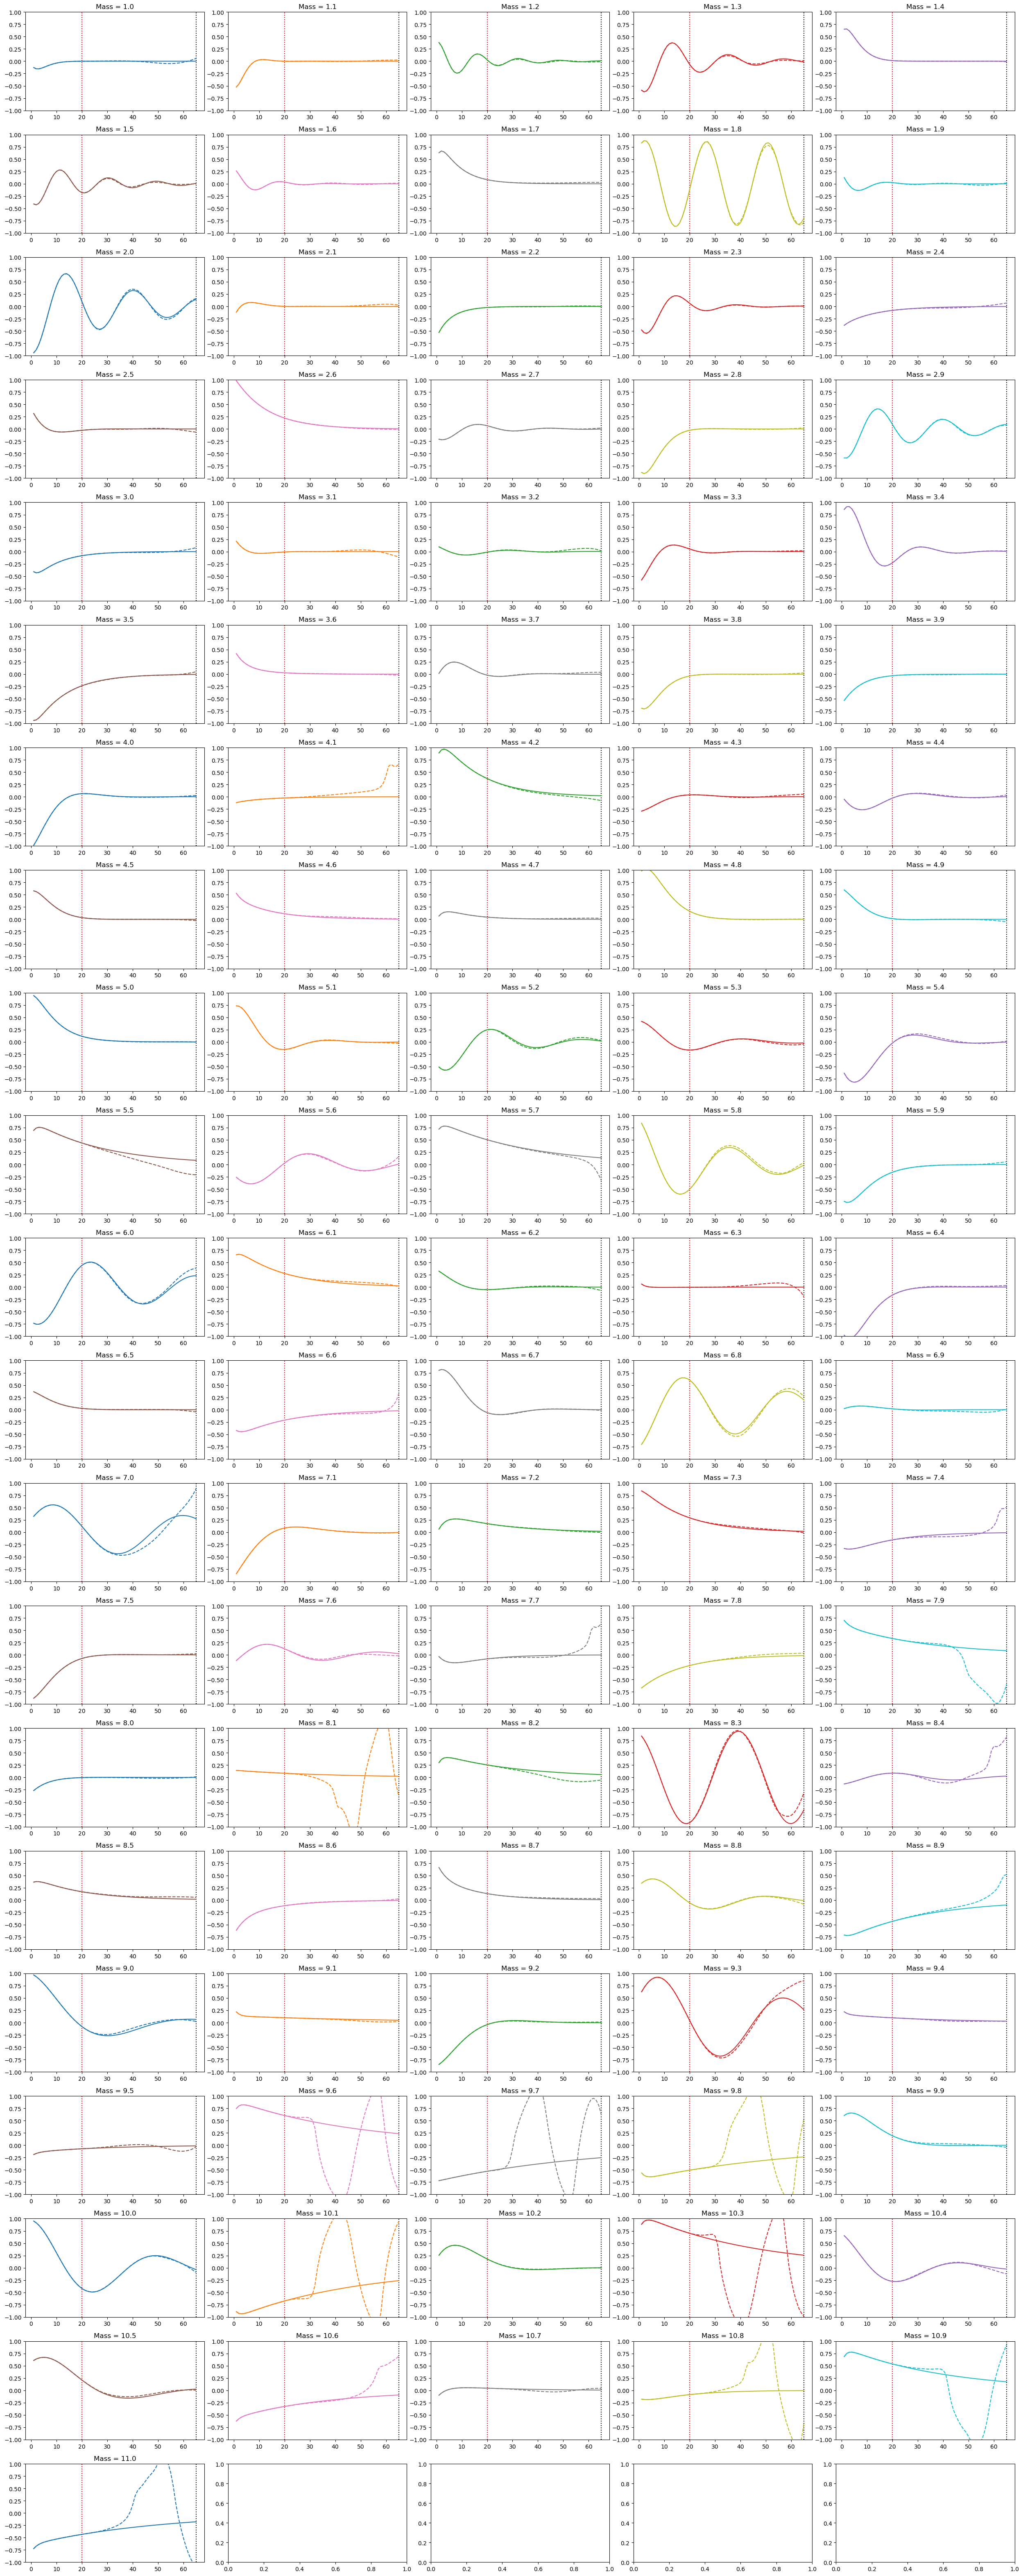

In [4]:
import math

xref = x[:,:,0]
vref = x[:,:,1]
xpred = xcurr[:,:,0]
vpred = xcurr[:,:,1]
tref = np.arange(xref.shape[-1])+1
tpred = np.arange(xpred.shape[-1])+1

masses = val_data.masses
n_mass = len(masses)
n_col = 5
n_row = math.ceil(n_mass/n_col)

fig,axes = plt.subplots(n_row,n_col,figsize=(5*n_col,3*n_row))

for idx in range(xref.shape[0]):
    irow = idx//n_col
    icol = idx % n_col
    plt.sca(axes[irow,icol])
    plt.plot(tref,xref[idx:idx+1].T,color=f"C{idx}",zorder=1)
    plt.plot(tpred,xpred[idx:idx+1].T,linestyle='--',color=f"C{idx}",zorder=1)
    plt.ylim([-1,1])
    plt.title(f"Mass = {masses[idx]:.1f}")
    plt.axvline(max_seq_length,color='k',linestyle=':',zorder=0)
    plt.axvline(tstart,color='red',linestyle=':',zorder=0)
plt.tight_layout()
#plt.savefig("allMasses_timeSeries_smallTest_noPosEnc.png")

# fix $\beta = 2$ and study ICL performance in $(m,k)$ plane

## fully pre-trained model - next step MSE
For a grid of points in the $(m,k)$ plane, sample 100 sequences with random $(x_0,v_0)$ and look at next-step MSE as a function of context length

In [5]:
model_name = "random_DampedSHO_xvInput_noContext"
#date = "17Dec24_1621"
date = "06Jan25_1255"
model, kwargs = load_model(model_name,date)
dt = kwargs['dt']

Using RoPE
number of parameters: 0.20M


In [6]:
test_m = np.linspace(1,10,50)
dm = test_m[1]-test_m[0]
test_k = np.linspace(10,20,50)
dk = test_k[1]-test_k[0]

num_trajectories = 100
max_seq_len = 65
beta = 2

results = np.zeros((max_seq_len-1,len(test_m),len(test_k)))
for i,m in enumerate(test_m):
    for j,k in enumerate(test_k):
        val_data = DampedSHODatasetXV(num_trajectories=num_trajectories,masses=m,k=k,beta=beta,seq_len=max_seq_len,dt=dt)
        xvt = val_data.xv
        with torch.no_grad():
            pred = model(xvt)
            mse = torch.mean(torch.sum((pred[:,:-1,:]-xvt[:,1:,:])**2,dim=-1),dim=0)
            for k in range(mse.shape[0]):
                results[k,i,j] = mse[k]

Text(7.2, 19.5, 'Context = 21')

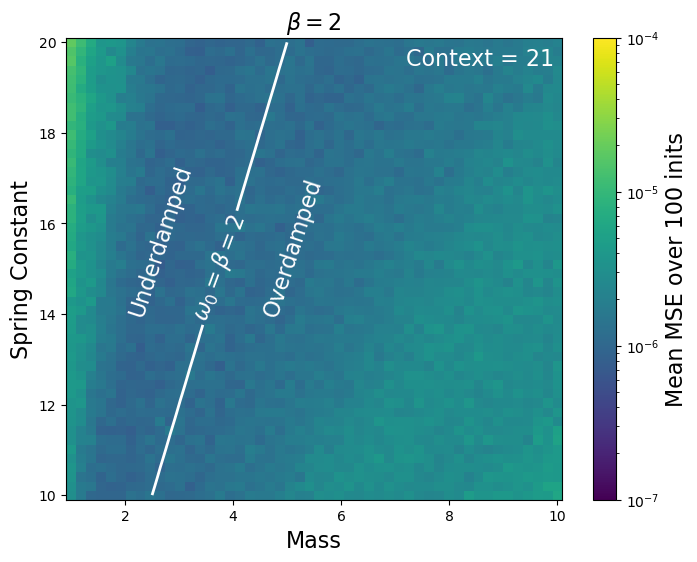

In [12]:
from matplotlib.colors import LogNorm
N_ctx = 20

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(test_m, test_k)
Z = results[N_ctx]
heatmap = plt.imshow(Z.T, extent=[test_m[0]-0.5*dm, test_m[-1]+0.5*dm, test_k[0]-0.5*dk, test_k[-1]+0.5*dk],
                     origin='lower', cmap='viridis', aspect='auto',norm=LogNorm(vmin=1e-7,vmax=1e-4))
w0 = np.sqrt(Y/X)
contour = plt.contour(X, Y, w0, levels=[beta], colors='white', linewidths=2)
plt.clabel(contour, inline=True, fontsize=16, fmt=f"$\\omega_0 = \\beta = {beta}$")  # Label the contour line

# Add a color bar
cbar = plt.colorbar(heatmap)
cbar.set_label('Mean MSE over 100 inits',fontsize=16)
# Add labels and title
plt.xlabel('Mass',fontsize=16)
plt.ylabel('Spring Constant',fontsize=16)
plt.title(f"$\\beta = {beta}$",fontsize=16)

plt.text(2,14,"Underdamped",rotation=72,color='white',fontsize=16)
plt.text(4.5,14,"Overdamped",rotation=72,color='white',fontsize=16)
plt.text(7.2,19.5,f"Context = {N_ctx+1}",rotation=0,color='white',fontsize=16)

In [13]:
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation, PillowWriter

fig,ax = plt.subplots(figsize=(8, 6))
X, Y = np.meshgrid(test_m, test_k)
Z = results[0]
norm = LogNorm(vmin=1e-7,vmax=1e-4)
heatmap = plt.imshow(Z.T, extent=[test_m[0]-0.5*dm, test_m[-1]+0.5*dm, test_k[0]-0.5*dk, test_k[-1]+0.5*dk],
                     origin='lower', cmap='viridis', aspect='auto',norm=norm)
w0 = np.sqrt(Y/X)
contour = plt.contour(X, Y, w0, levels=[beta], colors='white', linewidths=2)
plt.clabel(contour, inline=True, fontsize=16, fmt=f"$\\omega_0 = \\beta = {beta}$")  # Label the contour line

# Add a color bar
cbar = plt.colorbar(heatmap)
cbar.set_label('Mean MSE over 100 inits',fontsize=16)
# Add labels and title
plt.xlabel('Mass',fontsize=16)
plt.ylabel('Spring Constant',fontsize=16)
plt.title(f"$\\beta = {beta}$",fontsize=16)
plt.text(2,14,"Underdamped",rotation=72,color='white',fontsize=16)
plt.text(4.5,14,"Overdamped",rotation=72,color='white',fontsize=16)
tx_context = plt.text(7.2,19.5,"Context = 1",rotation=0,color='white',fontsize=16)

# Update function for animation
def update(frame):
    heatmap.set_data(results[frame].T)  # Update the image data
    #ax.set_title(f"Context = {frame+1}, $\\beta = {beta}$")  # Update the title with frame number
    tx_context.set_text(f"Context = {frame+1}")
    return [heatmap]

# Create the animation
ani = FuncAnimation(fig, update, frames=results.shape[0], interval=250, blit=True)

# Save the animation as a GIF
output_filename = f"animation_beta{beta}.gif"
ani.save(output_filename, writer=PillowWriter(fps=3))

# Close the figure after saving
plt.close(fig)

Now look at some sample waveforms in the $(m,k)$ plane to get a sense of where the model struggles. It seems to take the longest (most context) to get overdamped solutions correct, and among those the hardest are "lower right" -- low $k$, high $m$. This corresponds to the smallest $\omega_0$ values and so they are the "most overdamped", i.e. a long decay to 0 as a time series

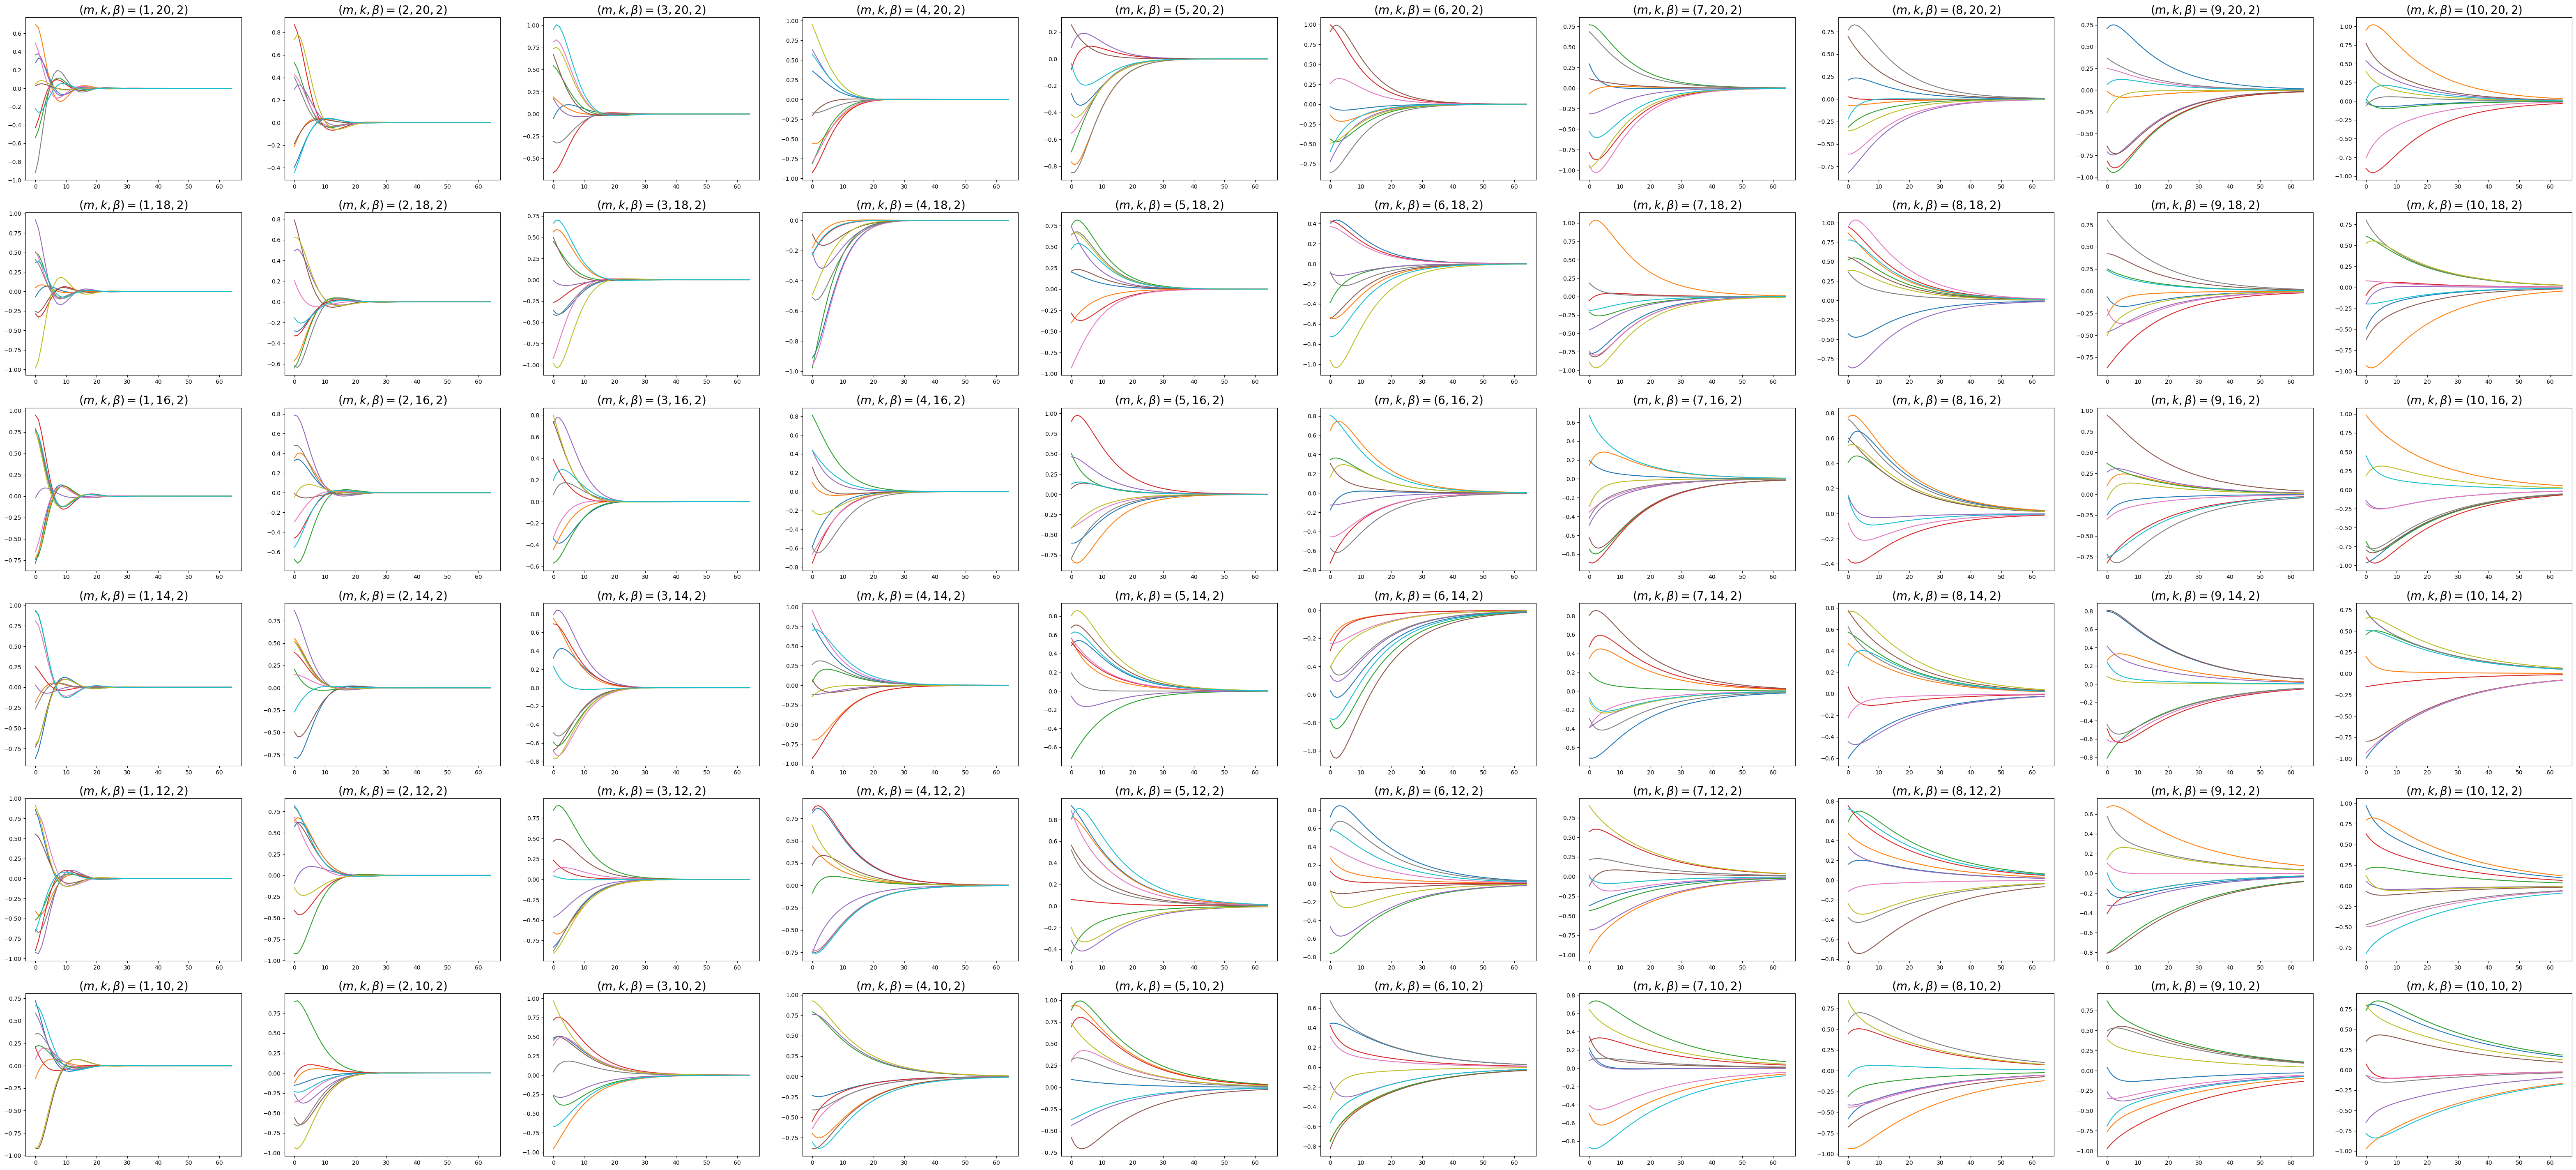

In [43]:
masses = np.arange(1,11)
ks = np.arange(10,22,2)

axdim=(8,6)
fig,axes = plt.subplots(len(ks),len(masses),figsize=(len(masses)*axdim[0],len(ks)*axdim[1]))
num_waveforms = 10

for i,k in enumerate(ks[::-1]):
    for j,m in enumerate(masses):
        val_data = DampedSHODatasetXV(num_trajectories=num_waveforms,masses=m,k=k,beta=beta,seq_len=max_seq_len,dt=dt)
        xt = val_data.xt.squeeze(-1)
        time = np.arange(xt.shape[1])
        plt.sca(axes[i,j])
        plt.plot(time,xt.T)
        w0 = np.sqrt(k/m)
        title = f"$(m,k,\\beta) = ({m},{k},{beta})$"
        plt.title(title,fontsize=20)

It seems like the point at which ICL MSE "bottoms out" (gets very accurate) aligns with where the oscillations and/or exponential decay "flatten out". Test this hypothesis by plotting context time at which MSE dips below 1e-4 as a function of (m,k,beta)

In [16]:
mse_thresh = 1e-5
decay_times = []
mse_thresh_times = []
w0s = []
time_ratios = np.zeros((results.shape[1],results.shape[2]))
decay_times_arr = np.zeros((results.shape[1],results.shape[2]))
mse_thresh_times_arr = np.zeros((results.shape[1],results.shape[2]))
for i,m in enumerate(test_m):
    for j,k in enumerate(test_k):
        w0 = np.sqrt(k/m)
        mses = results[:,i,j]
        #times = dt*np.arange(len(mses))
        #mse_thresh_time = np.interp(mse_thresh,mses,times)
        mse_thresh_time = dt*(np.min(np.argwhere(results[:,i,j]<mse_thresh))+1)
        if beta <= w0:
            decay_time = 1/beta
        else:
            decay_time = 1/(beta - np.sqrt(beta**2 - w0**2))
        w0s.append(w0)
        decay_times.append(decay_time)
        mse_thresh_times.append(mse_thresh_time)
        time_ratios[i,j] = mse_thresh_time/decay_time
        decay_times_arr[i,j] = decay_time
        mse_thresh_times_arr[i,j] = mse_thresh_time
w0s=np.array(w0s)
decay_times=np.array(decay_times)
mse_thresh_times=np.array(mse_thresh_times)

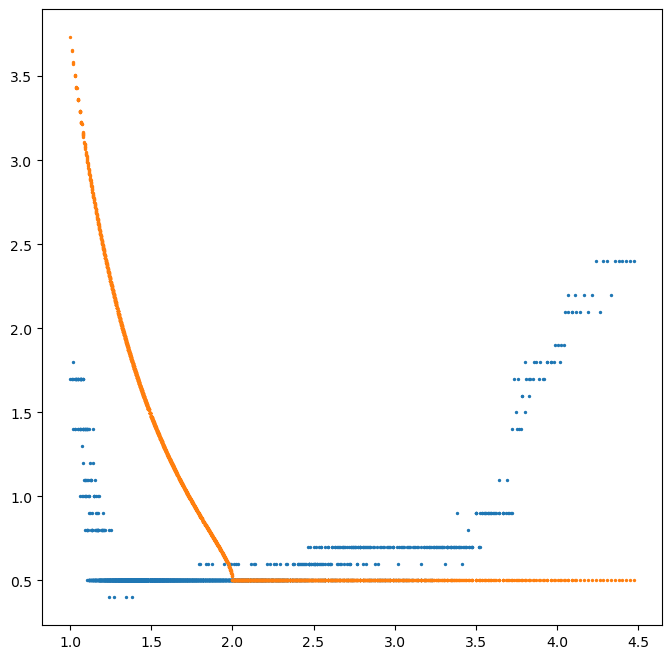

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(w0s,mse_thresh_times,s=2)
plt.scatter(w0s,decay_times,s=2)

Text(4.5, 14, 'Overdamped')

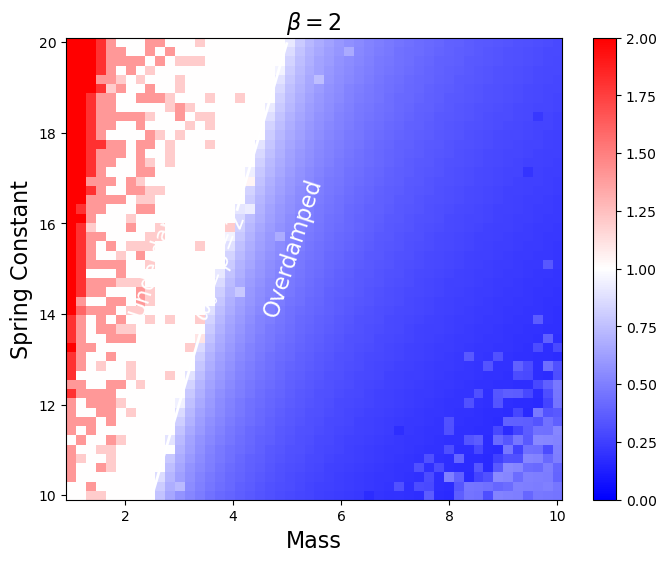

In [18]:
from matplotlib.colors import LogNorm, Normalize
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(test_m, test_k)
heatmap = plt.imshow(time_ratios.T, extent=[test_m[0]-0.5*dm, test_m[-1]+0.5*dm, test_k[0]-0.5*dk, test_k[-1]+0.5*dk],
                     origin='lower', cmap='bwr', aspect='auto',norm=Normalize(vmin=0,vmax=2))
w0 = np.sqrt(Y/X)
contour = plt.contour(X, Y, w0, levels=[beta], colors='white', linewidths=2)
plt.clabel(contour, inline=True, fontsize=16, fmt=f"$\\omega_0 = \\beta = {beta}$")  # Label the contour line

# Add a color bar
cbar = plt.colorbar(heatmap)
#cbar.set_label('Mean MSE over 100 inits',fontsize=16)
# Add labels and title
plt.xlabel('Mass',fontsize=16)
plt.ylabel('Spring Constant',fontsize=16)
plt.title(f"$\\beta = {beta}$",fontsize=16)

plt.text(2,14,"Underdamped",rotation=72,color='white',fontsize=16)
plt.text(4.5,14,"Overdamped",rotation=72,color='white',fontsize=16)

Text(4.5, 14, 'Overdamped')

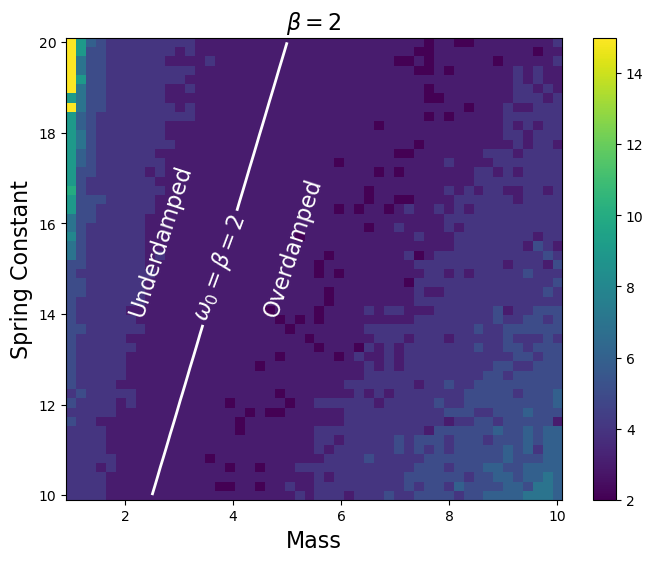

In [84]:
from matplotlib.colors import LogNorm, Normalize
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(test_m, test_k)
heatmap = plt.imshow(mse_thresh_times_arr.T/dt, extent=[test_m[0]-0.5*dm, test_m[-1]+0.5*dm, test_k[0]-0.5*dk, test_k[-1]+0.5*dk],
                     origin='lower', cmap='viridis', aspect='auto',norm=Normalize())
w0 = np.sqrt(Y/X)
contour = plt.contour(X, Y, w0, levels=[beta], colors='white', linewidths=2)
plt.clabel(contour, inline=True, fontsize=16, fmt=f"$\\omega_0 = \\beta = {beta}$")  # Label the contour line

# Add a color bar
cbar = plt.colorbar(heatmap)
#cbar.set_label('Mean MSE over 100 inits',fontsize=16)
# Add labels and title
plt.xlabel('Mass',fontsize=16)
plt.ylabel('Spring Constant',fontsize=16)
plt.title(f"$\\beta = {beta}$",fontsize=16)

plt.text(2,14,"Underdamped",rotation=72,color='white',fontsize=16)
plt.text(4.5,14,"Overdamped",rotation=72,color='white',fontsize=16)

# other stuff

In [20]:
test_m = np.linspace(1,10,50)
dm = test_m[1]-test_m[0]
test_k = np.linspace(10,20,50)
dk = test_k[1]-test_k[0]

num_trajectories = 100
max_seq_len = 65
beta = 2

results = np.zeros((max_seq_len-1,len(test_m),len(test_k)))
for i,m in enumerate(test_m):
    for j,k in enumerate(test_k):
        val_data = DampedSHODatasetXV(num_trajectories=num_trajectories,masses=m,k=k,beta=beta,seq_len=max_seq_len,dt=dt)
        xvt = val_data.xv
        with torch.no_grad():
            pred = model(xvt)
            mse = torch.mean(torch.sum((pred[:,:-1,:]-xvt[:,1:,:])**2,dim=-1),dim=0)
            for k in range(mse.shape[0]):
                results[k,i,j] = mse[k]

Text(0, 0.5, 'MSE for next timestep')

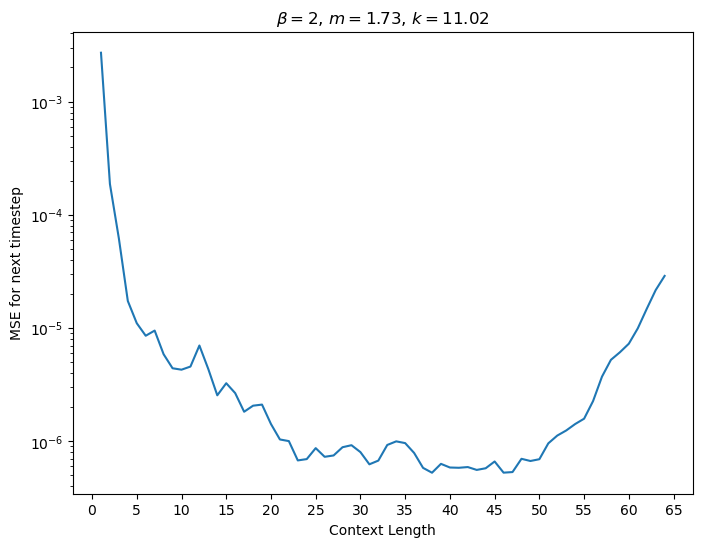

In [21]:
ik = 5
im = 4
num_ctx = np.arange(results.shape[0])+1
plt.figure(figsize=(8,6))
plt.plot(num_ctx,results[:,ik,im])
plt.yscale('log')
xt = plt.xticks(np.arange(0,70,5))
plt.title(f"$\\beta = {beta}$, $m = {test_m[im]:.2f}$, $k = {test_k[ik]:.2f}$")
plt.xlabel("Context Length")
plt.ylabel("MSE for next timestep")

In [185]:
%matplotlib widget
from ipywidgets import interact
import ipywidgets as widgets

with plt.ioff():
    fig,axes = plt.subplots(figsize=(8,6))

ik = 5
im = 4
num_ctx = np.arange(results.shape[0])+1

line, = plt.plot(num_ctx,results[:,ik,im])
plt.yscale('log')
xt = plt.xticks(np.arange(0,70,5))
plt.title(f"$\\beta = {beta}$, $m = {test_m[im]:.2f}$, $k = {test_k[ik]:.2f}$")
plt.xlabel("Context Length")
plt.ylabel("MSE for next timestep")

# Function to update the plot
m_slider = widgets.IntSlider(value=0, min=0, max=len(test_m)-1, step=1, description="mass")
k_slider = widgets.IntSlider(value=0, min=0, max=len(test_k)-1, step=1, description="k")

def update_plot(change):
    im = m_slider.value
    ik = k_slider.value
    mcurr = test_m[im]
    kcurr = test_k[ik]
    w0 = np.sqrt(kcurr/mcurr)
    prefix = ""
    if beta == 0:
        prefix = "No damping"
    elif beta < w0 and beta > 0:
        prefix = "Underdamped"
    elif beta == w0:
        prefix = "Critical Damping"
    else:
        prefix = "Overdamped"
    plt.title(f"{prefix}: $\\beta = {beta}$, $m = {test_m[im]:.2f}$, $k = {test_k[ik]:.2f}$")
    line.set_ydata(results[:,ik,im])
    fig.canvas.draw_idle()

# Create an interactive slider
m_slider.observe(update_plot)
k_slider.observe(update_plot)
widgets.VBox([widgets.HBox([m_slider,k_slider]),fig.canvas])

In [175]:
%matplotlib inline